In [6]:
import uproot,scipy
import numpy as np, pandas as pd
from scipy.constants import golden
import matplotlib as mpl, matplotlib.patches as patches, matplotlib.pylab as plt
from scipy.optimize import curve_fit


#presets for plot style
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
rc = plt.rc

rc('text', usetex=False)

rc('font', family='serif')
rc('font', size=18)

rc('xtick', labelsize=18)
rc('ytick', labelsize=18)

rc('axes', labelsize=18)
rc('legend', fontsize=18)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

def findindex(xvals,xval): 
    minima = 66e6
    for i,elem in enumerate(xvals):
        # Update minimum difference from xval and index of the minimum difference
        if abs(xval-elem) < minima: 
            minima = abs(xval-elem) 
            index = i
    return index

def findmax(xvals,yvals,xmin,xmax): 
    xminindex = -666
    xmaxindex = -666
    # Find the indexes of the limits using findindex function
    xminindex = findindex(xvals,xmin)
    xmaxindex = findindex(xvals,xmax)
    # Find the max y value and the x value which is at the same index
    maxy = max(yvals[xminindex:xmaxindex])
    maxx = xvals[np.where(yvals==maxy)[0][0]]
    #maxx = 0
    return maxx,maxy #return peak as x,y coordinate tuple

def SetLandau():
    global LandauXs
    global LandauYs
    lookuptable = np.loadtxt("landaulookuptable.txt",float)
    LandauXs = lookuptable[:,0]
    LandauYs = lookuptable[:,-1]
    return
SetLandau()

def Landau(x, location,fwhm,renormalization):
    #print(type(x))
    u=(x-location)*4/fwhm
    renormalization = 8/5*renormalization
    return renormalization * np.exp(-u/2 - np.exp(-u)/2)

def Landau2(xs,location,fwhm,renormalization):
    if "array" in str(type(xs)) or "list" in str(type(xs)):
        linapprox=[]
        for x in xs:
            u=(x-location)/fwhm
            if u < -3.8 or u > 500: linapp = 0
            else:
                for i in range(len(LandauXs)):
                    if LandauXs[i] < u: index = i
                    else: break
                linapp = renormalization*(u-LandauXs[index])*(LandauYs[index+1]-LandauYs[index])/(LandauXs[index+1]-LandauXs[index])+renormalization*LandauYs[index]
            linapprox.append(linapp)
    else:
        u=(xs-location)/fwhm
        if u < -3.8 or u > 500: linapprox = 0
        else:
            for i in range(len(LandauXs)):
                if LandauXs[i] < u: index = i
                else: break

            linapprox = renormalization*(u-LandauXs[index])*(LandauYs[index+1]-LandauYs[index])/(LandauXs[index+1]-LandauXs[index])+renormalization*LandauYs[index]
    return linapprox

def gaus(x, normalization, location, stdev):
    return normalization* np.exp(-0.5*((x - location)/stdev)**2)



In [22]:

for i in [1.7,3.2,5.1,7.1,9.1]:
    d = {a:[] for a in "avg_x avg_y avg_z avg_t TDCR TDCL ADCL ADCR ADCL_time ADCR_time layer component Edep eventn".split()}
    print(f"\nFile out_{i}.root")
    f=uproot.open(f"../out_{i}.root")
    fcal=f["fcal"]
    header = f["header"]
    
    flayer = fcal["layer"].array()
    fcomponent = fcal["component"].array()
    fADC_ord = fcal["ADC_order"].array()
    fADC_time = fcal["ADC_time"].array()
    fADC_ADC = fcal["ADC_ADC"].array()
    fTDC_ord = fcal["TDC_order"].array()
    fTDC_TDC = fcal["TDC_TDC"].array()
    ftotEdep = fcal["totEdep"].array()
    favgx = fcal["avg_x"].array()
    favgy = fcal["avg_y"].array()
    favgz = fcal["avg_z"].array()
    favgt = fcal["avg_t"].array()

    eventn = header["evn"].array()

    for xs,ys,zs,ts,layers,components,ADCs,ADCtimes,ADCords,TDCs,Edeps,event in zip(favgx,favgy,favgz,favgt,flayer,fcomponent,fADC_ADC,fADC_time,fADC_ord,fTDC_TDC,ftotEdep,eventn):
        #if event[0] > 10: break
        print(f"Event number {event[0]}",end="\r")
        for x,y,z,t,layer,component,ADC,ADCtime,ADCord,TDC,Edep in zip(xs,ys,zs,ts,layers,components,ADCs,ADCtimes,ADCords,TDCs,Edeps):

            if ADCord == 0:
                d["avg_x"].append(x)
                d["avg_y"].append(y)
                d["avg_z"].append(z)
                d["avg_t"].append(t)
                d["layer"].append(int(layer))
                d["component"].append(int(component))
                d["TDCR"].append(TDC)
                d["ADCR"].append(ADC)
                d["ADCR_time"].append(ADCtime)
                d["Edep"].append(Edep)
                d["eventn"].append(int(eventcount+event[0]))
            elif ADCord == 1:
                d["TDCL"].append(TDC)
                d["ADCL"].append(ADC)
                d["ADCL_time"].append(ADCtime)

    print("\nDone!")
    if i == 1.7: df17 = pd.DataFrame(d)
    if i == 3.2: df32 = pd.DataFrame(d)
    if i == 5.1: df51 = pd.DataFrame(d)
    if i == 7.1: df71 = pd.DataFrame(d)
    if i == 9.1: df91 = pd.DataFrame(d)


File out_1.7.root
Event number 10000.0
Done!

File out_3.2.root
Event number 10000.0
Done!

File out_5.1.root
Event number 10000.0
Done!

File out_7.1.root
Event number 10000.0
Done!

File out_9.1.root
Event number 9625.0
Done!


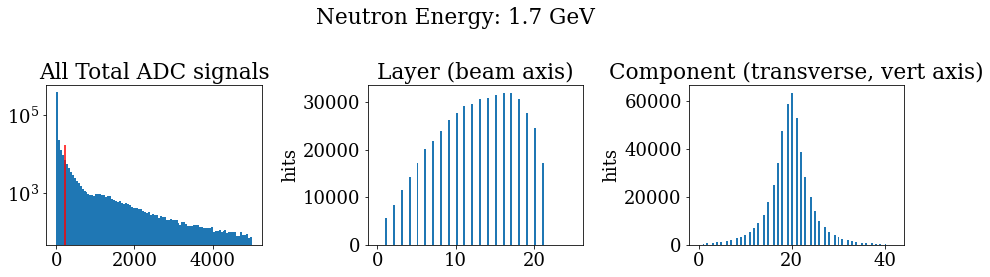

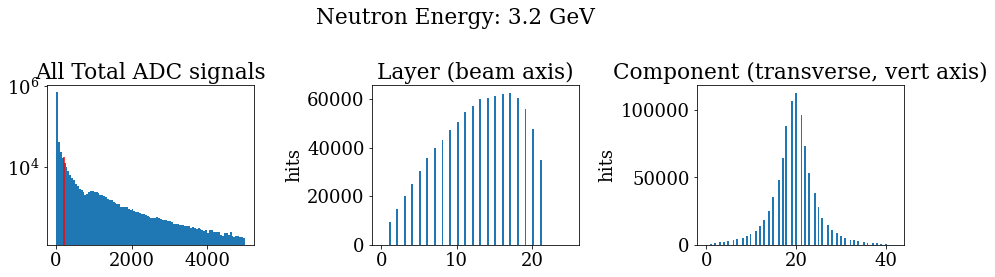

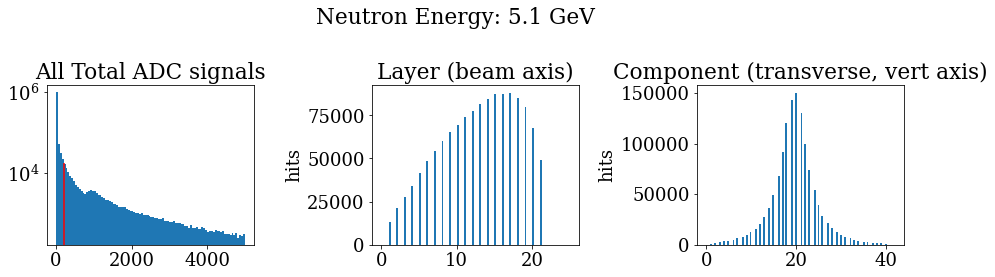

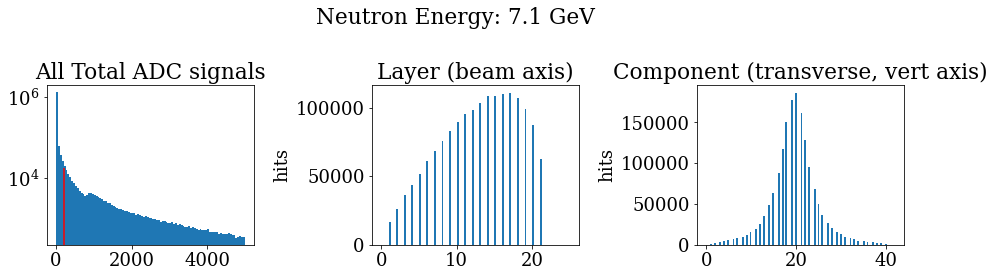

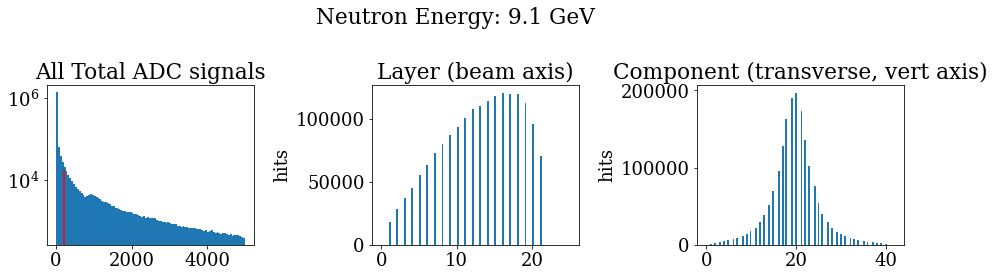

In [25]:
MIP = 870.3
minGeoMean=MIP/4
MIPcut = f"sqrt(ADCR*ADCL)>{minGeoMean}"

fig,ax = plt.subplots(1,3,figsize=(13,4))
fig.suptitle("Neutron Energy: 1.7 GeV")
ax[0].set_title("All Total ADC signals")
ax[0].hist(np.sqrt(df17.ADCR*df17.ADCL),bins=100,range=(0,5000),log=1)
ax[0].vlines(minGeoMean,ymin=0,ymax=17500, color='r')
ax[1].set_title("Layer (beam axis)")
ax[1].set_ylabel("hits")
ax[1].hist(df17.layer,bins=100,range=(0,25))
ax[2].set_title("Component (transverse, vert axis)")
ax[2].set_ylabel("hits")
ax[2].hist(df17.component,bins=100,range=(0,42))
plt.show()

fig,ax = plt.subplots(1,3,figsize=(13,4))
fig.suptitle("Neutron Energy: 3.2 GeV")
ax[0].set_title("All Total ADC signals")
ax[0].hist(np.sqrt(df32.ADCR*df32.ADCL),bins=100,range=(0,5000),log=1)
ax[0].vlines(minGeoMean,ymin=0,ymax=17500, color='r')
ax[1].set_title("Layer (beam axis)")
ax[1].set_ylabel("hits")
ax[1].hist(df32.layer,bins=100,range=(0,25))
ax[2].set_title("Component (transverse, vert axis)")
ax[2].set_ylabel("hits")
ax[2].hist(df32.component,bins=100,range=(0,42))
plt.show()

fig,ax = plt.subplots(1,3,figsize=(13,4))
fig.suptitle("Neutron Energy: 5.1 GeV")
ax[0].set_title("All Total ADC signals")
ax[0].hist(np.sqrt(df51.ADCR*df51.ADCL),bins=100,range=(0,5000),log=1)
ax[0].vlines(minGeoMean,ymin=0,ymax=17500, color='r')
ax[1].set_title("Layer (beam axis)")
ax[1].set_ylabel("hits")
ax[1].hist(df51.layer,bins=100,range=(0,25))
ax[2].set_title("Component (transverse, vert axis)")
ax[2].set_ylabel("hits")
ax[2].hist(df51.component,bins=100,range=(0,42))
plt.show()

fig,ax = plt.subplots(1,3,figsize=(13,4))
fig.suptitle("Neutron Energy: 7.1 GeV")
ax[0].set_title("All Total ADC signals")
ax[0].hist(np.sqrt(df71.ADCR*df71.ADCL),bins=100,range=(0,5000),log=1)
ax[0].vlines(minGeoMean,ymin=0,ymax=17500, color='r')
ax[1].set_title("Layer (beam axis)")
ax[1].set_ylabel("hits")
ax[1].hist(df71.layer,bins=100,range=(0,25))
ax[2].set_title("Component (transverse, vert axis)")
ax[2].set_ylabel("hits")
ax[2].hist(df71.component,bins=100,range=(0,42))
plt.show()

fig,ax = plt.subplots(1,3,figsize=(13,4))
fig.suptitle("Neutron Energy: 9.1 GeV")
ax[0].set_title("All Total ADC signals")
ax[0].hist(np.sqrt(df91.ADCR*df91.ADCL),bins=100,range=(0,5000),log=1)
ax[0].vlines(minGeoMean,ymin=0,ymax=17500, color='r')
ax[1].set_title("Layer (beam axis)")
ax[1].set_ylabel("hits")
ax[1].hist(df91.layer,bins=100,range=(0,25))
ax[2].set_title("Component (transverse, vert axis)")
ax[2].set_ylabel("hits")
ax[2].hist(df91.component,bins=100,range=(0,42))
plt.show()

In [9]:
print(f"event==1 & {MIPcut}")

event==1 & sqrt(ADCR*ADCL)>435.15


In [23]:
d = {a:[] for a in "ADC hits".split()} #Edep

for event in range(max(df17.eventn)):
    if (event+1)%50 == 0: print(f"Event number {event+1}",end="\r")
    #n_Edep = sum(df17.query(f"eventn=={event+1} & {MIPcut}").Edep)
    #d["Edep"].append(n_Edep)
    
    n_ADC = sum(np.sqrt(df17.query(f"eventn=={event+1} & {MIPcut}").ADCR*df17.query(f"eventn=={event+1} & {MIPcut}").ADCL))
    d["ADC"].append(n_ADC)
    
    n_hit = len(df17.query(f"eventn=={event+1} & {MIPcut}").ADCR)
    d["hits"].append(n_hit)

df17events = pd.DataFrame(d)

In [24]:
d = {a:[] for a in "ADC hits".split()} #Edep

for event in range(max(df32.eventn)):
    if (event+1)%50 == 0: print(f"Event number {event+1}",end="\r")
    #n_Edep = sum(df17.query(f"eventn=={event+1} & {MIPcut}").Edep)
    #d["Edep"].append(n_Edep)
    
    n_ADC = sum(np.sqrt(df32.query(f"eventn=={event+1} & {MIPcut}").ADCR*df32.query(f"eventn=={event+1} & {MIPcut}").ADCL))
    d["ADC"].append(n_ADC)
    
    n_hit = len(df32.query(f"eventn=={event+1} & {MIPcut}").ADCR)
    d["hits"].append(n_hit)
print("\nDone!")
df32events = pd.DataFrame(d)

d = {a:[] for a in "ADC hits".split()} #Edep

for event in range(max(df71.eventn)):
    if (event+1)%50 == 0: print(f"Event number {event+1}",end="\r")
    #n_Edep = sum(df17.query(f"eventn=={event+1} & {MIPcut}").Edep)
    #d["Edep"].append(n_Edep)
    
    n_ADC = sum(np.sqrt(df71.query(f"eventn=={event+1} & {MIPcut}").ADCR*df71.query(f"eventn=={event+1} & {MIPcut}").ADCL))
    d["ADC"].append(n_ADC)
    
    n_hit = len(df71.query(f"eventn=={event+1} & {MIPcut}").ADCR)
    d["hits"].append(n_hit)
print("\nDone!")
df71events = pd.DataFrame(d)

d = {a:[] for a in "ADC hits".split()} #Edep

for event in range(max(df51.eventn)):
    if (event+1)%50 == 0: print(f"Event number {event+1}",end="\r")
    #n_Edep = sum(df17.query(f"eventn=={event+1} & {MIPcut}").Edep)
    #d["Edep"].append(n_Edep)
    
    n_ADC = sum(np.sqrt(df51.query(f"eventn=={event+1} & {MIPcut}").ADCR*df51.query(f"eventn=={event+1} & {MIPcut}").ADCL))
    d["ADC"].append(n_ADC)
    
    n_hit = len(df51.query(f"eventn=={event+1} & {MIPcut}").ADCR)
    d["hits"].append(n_hit)
print("\nDone!")
df51events = pd.DataFrame(d)

d = {a:[] for a in "ADC hits".split()} #Edep

for event in range(max(df91.eventn)):
    if (event+1)%50 == 0: print(f"Event number {event+1}",end="\r")
    #n_Edep = sum(df17.query(f"eventn=={event+1} & {MIPcut}").Edep)
    #d["Edep"].append(n_Edep)
    
    n_ADC = sum(np.sqrt(df91.query(f"eventn=={event+1} & {MIPcut}").ADCR*df91.query(f"eventn=={event+1} & {MIPcut}").ADCL))
    d["ADC"].append(n_ADC)
    
    n_hit = len(df91.query(f"eventn=={event+1} & {MIPcut}").ADCR)
    d["hits"].append(n_hit)
print("\nDone!")
df91events = pd.DataFrame(d)

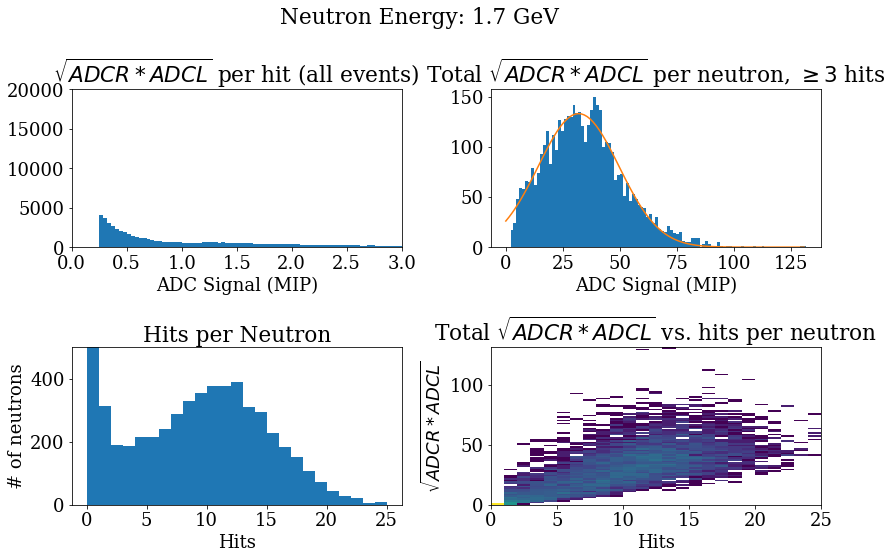

Average Energy Deposition: 31.91 GeV,     Energy Deposition stdev: 17.66 GeV
Energy Resolution: 0.55
Calorimeter Efficiency for at least 1 hit: 0.4929
Calorimeter Efficiency for at least 3 hits: 0.4426


In [27]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
fig.suptitle("Neutron Energy: 1.7 GeV")

#ax[0][0].hist(n_Edeps,100)
#ax[0][0].set_title("Total Enery deposited per muon")
#ax[0][0].set_xlabel("Energy (MeV)")
#ax[0][0].set_ylim(0,170)
ax[0][0].hist(np.sqrt(df17.query(MIPcut).ADCR*df17.query(MIPcut).ADCL)/MIP,2000)
ax[0][0].set_xlabel("ADC Signal (MIP)")
ax[0][0].set_title("$\sqrt{ADCR*ADCL}$ per hit (all events)")
ax[0][0].set_xlim(0,max(np.sqrt(df17.ADCR*df17.ADCL)/MIP)//20)
ax[0][0].set_ylim(0,20000)

count,binedges,bars=ax[0][1].hist(df17events.query("hits > 2").ADC/MIP,100)
ax[0][1].set_title("Total $\sqrt{ADCR*ADCL}$ per neutron, $\\geq3$ hits")
ax[0][1].set_xlabel("ADC Signal (MIP)")
#ax[0][1].set_ylim(0,170)

bincenters = binedges[1:]/2+binedges[:-1]/2
coeff, covar = curve_fit(gaus, bincenters, count,p0=(150,100,30))
ax[0][1].plot(np.linspace(0,max(bincenters),100),gaus(np.linspace(0,max(bincenters),100),*coeff),label="Gaussian Fit")

ax[1][0].hist(df17events.hits,max(df17events.hits))
ax[1][0].set_title("Hits per Neutron")
ax[1][0].set_xlabel("Hits")
#ax[1][0].set_yscale("log")
ax[1][0].set_ylabel("# of neutrons")
#ax[1][0].set_xlim(0,max(df.Edep)//20)
ax[1][0].set_ylim(0,500)

ax[1][1].hist2d(df17events.hits,df17events.ADC/MIP,bins=[max(df17events.hits),100],cmin=1,norm=mpl.colors.LogNorm())
ax[1][1].set_title("Total $\sqrt{ADCR*ADCL}$ vs. hits per neutron")
ax[1][1].set_xlabel("Hits")
ax[1][1].set_ylabel("$\sqrt{ADCR*ADCL}$")

plt.show()

efficiency1=np.count_nonzero(df17events.hits)/len(df17events.hits)
geq10hits = 0
for hits in df17events.hits:
    if hits > 2: geq10hits +=1
efficiency10=geq10hits/len(df17events.hits)
print(f"Average Energy Deposition: {coeff[1]:.2f} GeV,     Energy Deposition stdev: {abs(coeff[2]):.2f} GeV")
print(f"Energy Resolution: {abs(coeff[2])/coeff[1]:.2f}")
print(f"Calorimeter Efficiency for at least 1 hit: {efficiency1}")
print(f"Calorimeter Efficiency for at least 3 hits: {efficiency10}")

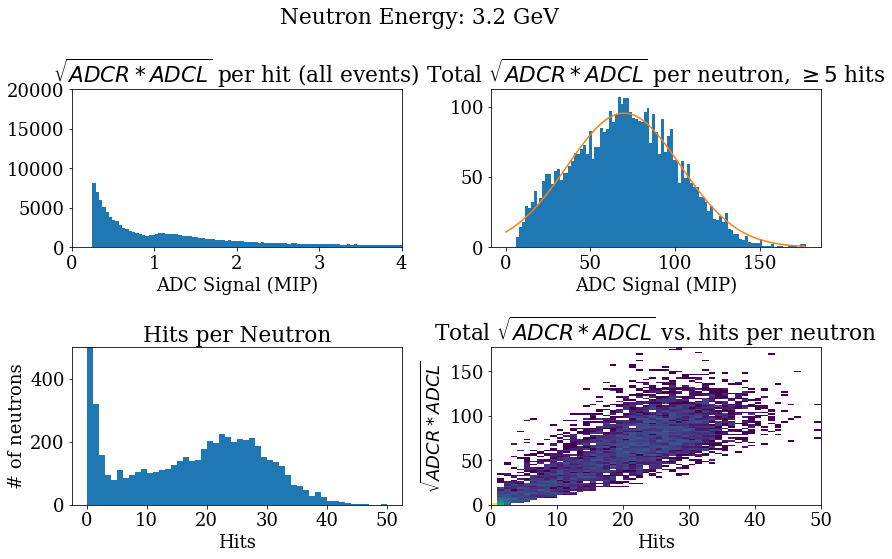

Average Energy Deposition: 69.79 GeV,     Energy Deposition stdev: 33.47 GeV
Energy Resolution: 0.48
Calorimeter Efficiency for at least 1 hit: 0.5279
Calorimeter Efficiency for at least 3 hits: 0.4515


In [29]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
fig.suptitle("Neutron Energy: 3.2 GeV")

#ax[0][0].hist(n_Edeps,100)
#ax[0][0].set_title("Total Enery deposited per muon")
#ax[0][0].set_xlabel("Energy (MeV)")
#ax[0][0].set_ylim(0,170)
ax[0][0].hist(np.sqrt(df32.query(MIPcut).ADCR*df32.query(MIPcut).ADCL)/MIP,2000)
ax[0][0].set_xlabel("ADC Signal (MIP)")
ax[0][0].set_title("$\sqrt{ADCR*ADCL}$ per hit (all events)")
ax[0][0].set_xlim(0,max(np.sqrt(df32.ADCR*df32.ADCL)/MIP)//20)
ax[0][0].set_ylim(0,20000)

count,binedges,bars=ax[0][1].hist(df32events.query("hits > 5").ADC/MIP,100)
ax[0][1].set_title("Total $\sqrt{ADCR*ADCL}$ per neutron, $\\geq5$ hits")
ax[0][1].set_xlabel("ADC Signal (MIP)")
#ax[0][1].set_ylim(0,170)

bincenters = binedges[1:]/2+binedges[:-1]/2
coeff, covar = curve_fit(gaus, bincenters, count,p0=(150,100,30))
ax[0][1].plot(np.linspace(0,max(bincenters),100),gaus(np.linspace(0,max(bincenters),100),*coeff),label="Gaussian Fit")

ax[1][0].hist(df32events.hits,max(df32events.hits))
ax[1][0].set_title("Hits per Neutron")
ax[1][0].set_xlabel("Hits")
#ax[1][0].set_yscale("log")
ax[1][0].set_ylabel("# of neutrons")
#ax[1][0].set_xlim(0,max(df.Edep)//20)
ax[1][0].set_ylim(0,500)

ax[1][1].hist2d(df32events.hits,df32events.ADC/MIP,bins=[max(df32events.hits),100],cmin=1,norm=mpl.colors.LogNorm())
ax[1][1].set_title("Total $\sqrt{ADCR*ADCL}$ vs. hits per neutron")
ax[1][1].set_xlabel("Hits")
ax[1][1].set_ylabel("$\sqrt{ADCR*ADCL}$")

plt.show()

efficiency1=np.count_nonzero(df32events.hits)/len(df32events.hits)
geq10hits = 0
for hits in df32events.hits:
    if hits > 5: geq10hits +=1
efficiency10=geq10hits/len(df32events.hits)
print(f"Average Energy Deposition: {coeff[1]:.2f} GeV,     Energy Deposition stdev: {abs(coeff[2]):.2f} GeV")
print(f"Energy Resolution: {abs(coeff[2])/coeff[1]:.2f}")
print(f"Calorimeter Efficiency for at least 1 hit: {efficiency1}")
print(f"Calorimeter Efficiency for at least 3 hits: {efficiency10}")

In [1]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
fig.suptitle("Neutron Energy: 5.1 GeV")

#ax[0][0].hist(n_Edeps,100)
#ax[0][0].set_title("Total Enery deposited per muon")
#ax[0][0].set_xlabel("Energy (MeV)")
#ax[0][0].set_ylim(0,170)
ax[0][0].hist(np.sqrt(df51.query(MIPcut).ADCR*df51.query(MIPcut).ADCL)/MIP,2000)
ax[0][0].set_xlabel("ADC Signal (MIP)")
ax[0][0].set_title("$\sqrt{ADCR*ADCL}$ per hit (all events)")
ax[0][0].set_xlim(0,max(np.sqrt(df51.ADCR*df51.ADCL)/MIP)//20)
ax[0][0].set_ylim(0,20000)

count,binedges,bars=ax[0][1].hist(df51events.query("hits > 15").ADC/MIP,100)
ax[0][1].set_title("Total $\sqrt{ADCR*ADCL}$ per neutron, $\\geq15$ hits")
ax[0][1].set_xlabel("ADC Signal (MIP)")
#ax[0][1].set_ylim(0,170)

bincenters = binedges[1:]/2+binedges[:-1]/2
coeff, covar = curve_fit(gaus, bincenters, count,p0=(150,100,30))
ax[0][1].plot(np.linspace(0,max(bincenters),100),gaus(np.linspace(0,max(bincenters),100),*coeff),label="Gaussian Fit")

ax[1][0].hist(df51events.hits,max(df51events.hits))
ax[1][0].set_title("Hits per Neutron")
ax[1][0].set_xlabel("Hits")
#ax[1][0].set_yscale("log")
ax[1][0].set_ylabel("# of neutrons")
#ax[1][0].set_xlim(0,max(df.Edep)//20)
ax[1][0].set_ylim(0,500)

ax[1][1].hist2d(df51events.hits,df51events.ADC/MIP,bins=[max(df51events.hits),100],cmin=1,norm=mpl.colors.LogNorm())
ax[1][1].set_title("Total $\sqrt{ADCR*ADCL}$ vs. hits per neutron")
ax[1][1].set_xlabel("Hits")
ax[1][1].set_ylabel("$\sqrt{ADCR*ADCL}$")

plt.show()

efficiency1=np.count_nonzero(df51events.hits)/len(df51events.hits)
geq10hits = 0
for hits in df51events.hits:
    if hits > 15: geq10hits +=1
efficiency10=geq10hits/len(df51events.hits)
print(f"Average Energy Deposition: {coeff[1]:.2f} GeV,     Energy Deposition stdev: {abs(coeff[2]):.2f} GeV")
print(f"Energy Resolution: {abs(coeff[2])/coeff[1]:.2f}")
print(f"Calorimeter Efficiency for at least 1 hit: {efficiency1}")
print(f"Calorimeter Efficiency for at least 15 hits: {efficiency10}")

NameError: name 'plt' is not defined

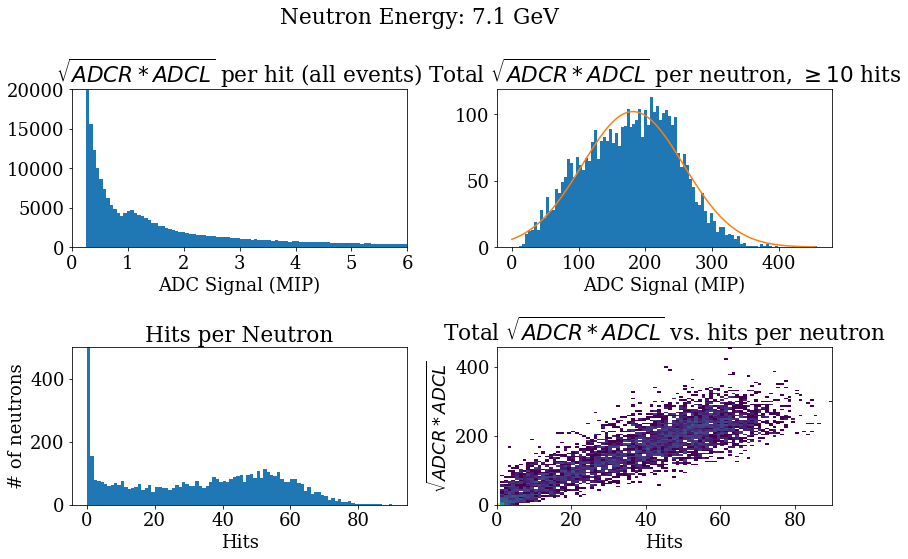

Average Energy Deposition: 181.51 GeV,     Energy Deposition stdev: 76.00 GeV
Energy Resolution: 0.42
Calorimeter Efficiency for at least 1 hit: 0.5002500750225067
Calorimeter Efficiency for at least 3 hits: 0.4222266680004001


In [32]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
fig.suptitle("Neutron Energy: 7.1 GeV")

#ax[0][0].hist(n_Edeps,100)
#ax[0][0].set_title("Total Enery deposited per muon")
#ax[0][0].set_xlabel("Energy (MeV)")
#ax[0][0].set_ylim(0,170)
ax[0][0].hist(np.sqrt(df71.query(MIPcut).ADCR*df71.query(MIPcut).ADCL)/MIP,2000)
ax[0][0].set_xlabel("ADC Signal (MIP)")
ax[0][0].set_title("$\sqrt{ADCR*ADCL}$ per hit (all events)")
ax[0][0].set_xlim(0,max(np.sqrt(df71.ADCR*df71.ADCL)/MIP)//20)
ax[0][0].set_ylim(0,20000)

count,binedges,bars=ax[0][1].hist(df71events.query("hits > 10").ADC/MIP,100)
ax[0][1].set_title("Total $\sqrt{ADCR*ADCL}$ per neutron, $\\geq10$ hits")
ax[0][1].set_xlabel("ADC Signal (MIP)")
#ax[0][1].set_ylim(0,170)

bincenters = binedges[1:]/2+binedges[:-1]/2
coeff, covar = curve_fit(gaus, bincenters, count,p0=(150,100,30))
ax[0][1].plot(np.linspace(0,max(bincenters),100),gaus(np.linspace(0,max(bincenters),100),*coeff),label="Gaussian Fit")

ax[1][0].hist(df71events.hits,max(df71events.hits))
ax[1][0].set_title("Hits per Neutron")
ax[1][0].set_xlabel("Hits")
#ax[1][0].set_yscale("log")
ax[1][0].set_ylabel("# of neutrons")
#ax[1][0].set_xlim(0,max(df.Edep)//20)
ax[1][0].set_ylim(0,500)

ax[1][1].hist2d(df71events.hits,df71events.ADC/MIP,bins=[max(df71events.hits),100],cmin=1,norm=mpl.colors.LogNorm())
ax[1][1].set_title("Total $\sqrt{ADCR*ADCL}$ vs. hits per neutron")
ax[1][1].set_xlabel("Hits")
ax[1][1].set_ylabel("$\sqrt{ADCR*ADCL}$")

plt.show()

efficiency1=np.count_nonzero(df71events.hits)/len(df71events.hits)
geq10hits = 0
for hits in df71events.hits:
    if hits > 10: geq10hits +=1
efficiency10=geq10hits/len(df71events.hits)
print(f"Average Energy Deposition: {coeff[1]:.2f} GeV,     Energy Deposition stdev: {abs(coeff[2]):.2f} GeV")
print(f"Energy Resolution: {abs(coeff[2])/coeff[1]:.2f}")
print(f"Calorimeter Efficiency for at least 1 hit: {efficiency1}")
print(f"Calorimeter Efficiency for at least 3 hits: {efficiency10}")

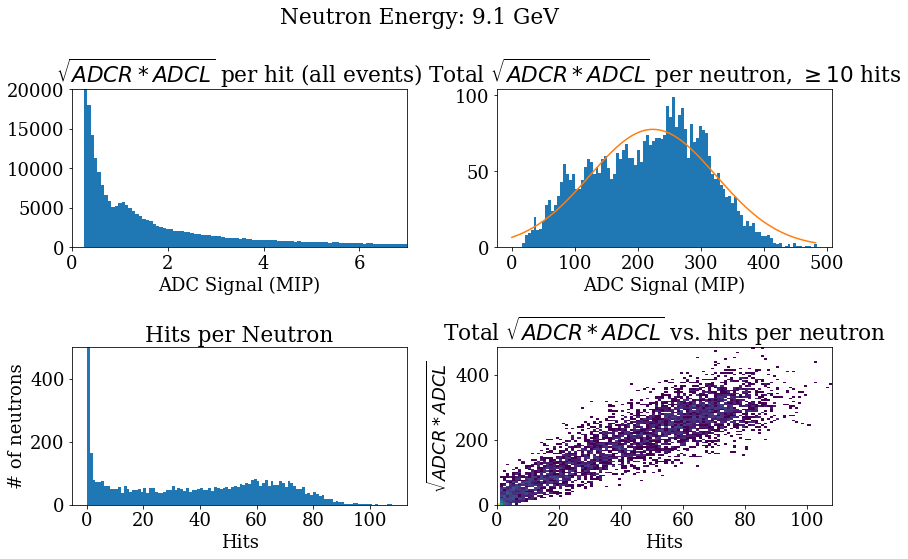

Average Energy Deposition: 224.08 GeV,     Energy Deposition stdev: 100.38 GeV
Energy Resolution: 0.45
Calorimeter Efficiency for at least 1 hit: 0.49163636363636365
Calorimeter Efficiency for at least 3 hits: 0.4154805194805195


In [33]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
fig.suptitle("Neutron Energy: 9.1 GeV")

#ax[0][0].hist(n_Edeps,100)
#ax[0][0].set_title("Total Enery deposited per muon")
#ax[0][0].set_xlabel("Energy (MeV)")
#ax[0][0].set_ylim(0,170)
ax[0][0].hist(np.sqrt(df91.query(MIPcut).ADCR*df91.query(MIPcut).ADCL)/MIP,2000)
ax[0][0].set_xlabel("ADC Signal (MIP)")
ax[0][0].set_title("$\sqrt{ADCR*ADCL}$ per hit (all events)")
ax[0][0].set_xlim(0,max(np.sqrt(df91.ADCR*df91.ADCL)/MIP)//20)
ax[0][0].set_ylim(0,20000)

count,binedges,bars=ax[0][1].hist(df91events.query("hits > 10").ADC/MIP,100)
ax[0][1].set_title("Total $\sqrt{ADCR*ADCL}$ per neutron, $\\geq10$ hits")
ax[0][1].set_xlabel("ADC Signal (MIP)")
#ax[0][1].set_ylim(0,170)

bincenters = binedges[1:]/2+binedges[:-1]/2
coeff, covar = curve_fit(gaus, bincenters, count,p0=(150,100,30))
ax[0][1].plot(np.linspace(0,max(bincenters),100),gaus(np.linspace(0,max(bincenters),100),*coeff),label="Gaussian Fit")

ax[1][0].hist(df91events.hits,max(df91events.hits))
ax[1][0].set_title("Hits per Neutron")
ax[1][0].set_xlabel("Hits")
#ax[1][0].set_yscale("log")
ax[1][0].set_ylabel("# of neutrons")
#ax[1][0].set_xlim(0,max(df.Edep)//20)
ax[1][0].set_ylim(0,500)

ax[1][1].hist2d(df91events.hits,df91events.ADC/MIP,bins=[max(df91events.hits),100],cmin=1,norm=mpl.colors.LogNorm())
ax[1][1].set_title("Total $\sqrt{ADCR*ADCL}$ vs. hits per neutron")
ax[1][1].set_xlabel("Hits")
ax[1][1].set_ylabel("$\sqrt{ADCR*ADCL}$")

plt.show()

efficiency1=np.count_nonzero(df91events.hits)/len(df91events.hits)
geq10hits = 0
for hits in df91events.hits:
    if hits > 10: geq10hits +=1
efficiency10=geq10hits/len(df91events.hits)
print(f"Average Energy Deposition: {coeff[1]:.2f} GeV,     Energy Deposition stdev: {abs(coeff[2]):.2f} GeV")
print(f"Energy Resolution: {abs(coeff[2])/coeff[1]:.2f}")
print(f"Calorimeter Efficiency for at least 1 hit: {efficiency1}")
print(f"Calorimeter Efficiency for at least 3 hits: {efficiency10}")

Actual Average: 115.90, Actual st.dev.: 39.94
Fit Average:    116.44, Fit st.dev.:    39.95


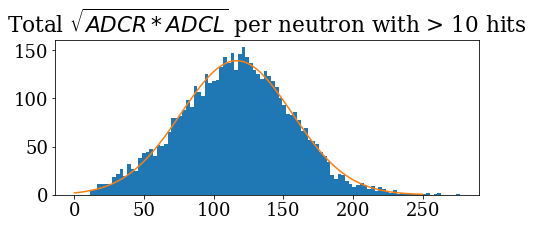

In [14]:
count,binedges,bars = plt.hist(dfevents.query("hits > 10").ADC/MIP,100)
bincenters = binedges[1:]/2+binedges[:-1]/2

avg = sum(bincenters*count)/sum(count)
stdev = np.sqrt(sum((bincenters-avg)**2*count)/sum(count))
coeff, covar = curve_fit(gaus, bincenters, count,p0=(150,100,30))

print(f"Actual Average: {avg:.2f}, Actual st.dev.: {stdev:.2f}")
print(f"Fit Average:    {coeff[1]:.2f}, Fit st.dev.:    {coeff[2]:.2f}")
plt.plot(np.linspace(0,250,100),gaus(np.linspace(0,250,100),*coeff),label="Gaussian Fit")
plt.title("Total $\sqrt{ADCR*ADCL}$ per neutron with > 10 hits")
plt.show()

In [112]:
hitsperlayer = []
for layer in range(max(df.layer)): #
    hitsperevent = []
    for event in range(max(df.eventn)): #
        if event%50==0: print(f"event {event} layer {layer+1}         ",end="\r")
        hitsperevent.append(len(df.query(f"eventn=={event+1} & layer=={layer+1} & sqrt(ADCR*ADCL)>500").layer)) #

    hitsperlayer.append(hitsperevent)


In [119]:
hitsperlayer[13][0:20]

[3, 1, 1, 3, 0, 2, 0, 0, 2, 1, 0, 0, 3, 0, 1, 0, 2, 3, 3, 0]

In [129]:
arrayhits = np.array(hitsperlayer)
arrayhits.flatten()

array([[1, 0, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 0, 1, 2],
       [0, 1, 1, ..., 0, 2, 0],
       ...,
       [0, 0, 1, ..., 3, 1, 3],
       [1, 0, 1, ..., 1, 0, 1],
       [0, 0, 1, ..., 3, 0, 1]])

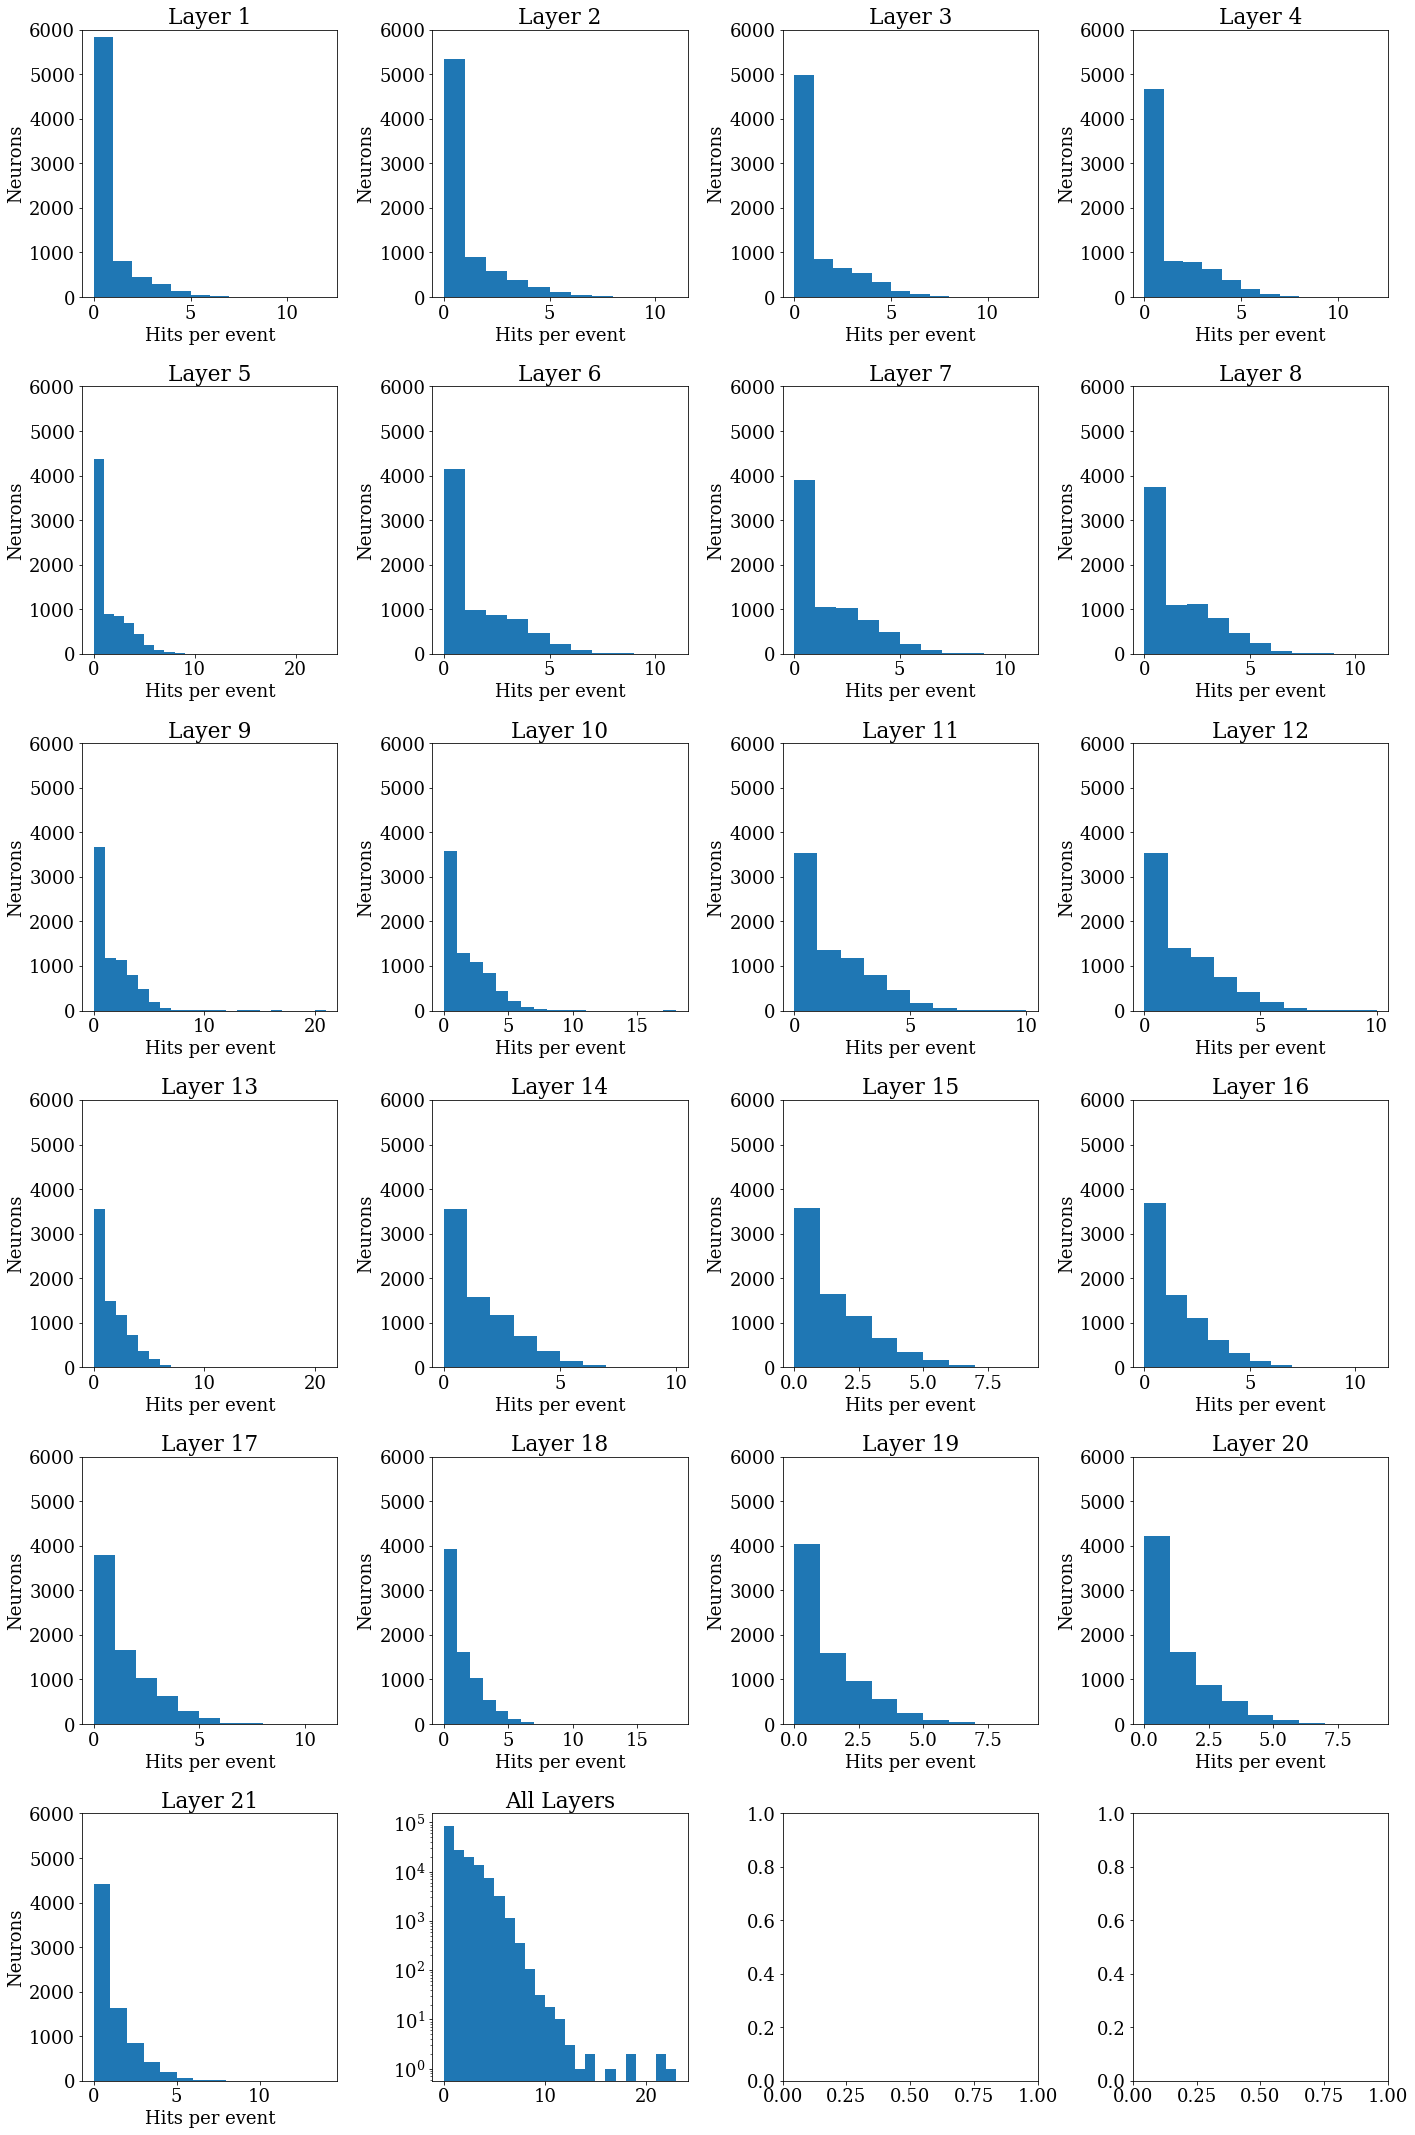

In [132]:
fig,ax = plt.subplots(6,4,figsize=(20,30))
counts = []
binedges = []
for i in range(21):
    ax[i//4][i%4].set_title(f"Layer {i+1}")
    ax[i//4][i%4].hist(hitsperlayer[i],bins=max(hitsperlayer[i]))
    ax[i//4][i%4].set_xlabel("Hits per event")
    ax[i//4][i%4].set_ylabel("Neurons")
    ax[i//4][i%4].set_ylim(0,6000)
ax[5][1].hist(arrayhits.flatten(),bins=max(arrayhits.flatten()))
ax[5][1].set_title("All Layers")
ax[5][1].set_yscale("log")
plt.show()
